# Example of selecting hyper-params for cross validation

# Initialization


## Imports

In [8]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# import seaborn as sns
import os
from IPython.display import display, Math, Latex
%matplotlib inline

In [9]:
import glob
import json
import sys
import re
sys.path.append('../')
import utils_src.ml_utils as ml_utils
from multiprocessing import Pool
import contextlib

## Initializations


In [10]:
linewidth = 3
font_size=22
matplotlib.rcParams.update({'font.size': font_size})
matplotlib.rc('xtick', labelsize=font_size)
matplotlib.rc('ytick', labelsize=font_size)
matplotlib.rc('lines', linewidth=linewidth)

In [11]:
params_to_display = ['use_trainval_set', 'model_name', 'model_variant', 'initial_learning_rate', 'max_epochs', 'LG_beta', 'LG_lambda',
                'SG_psi', 'LG_norm_groups_to_1', 'SG_num_K', 'SG_trainable', 'SG_gain', 'SG_gamma_lr', 'repeat']
params_rename = {
    'use_trainval_set':'isTest', 
    'model_name':'Model',
    'model_variant':'ModelType',
    'initial_learning_rate':'lr', 
    'max_epochs':'mxEp', 
    'LG_beta':'β',     
    'LG_lambda':'λ', 
    'LG_norm_groups_to_1':'muExNorm', 
    'SG_psi':'ψ',
    'SG_num_K':'K', 
    'SG_trainable':'is_SG', 
    'SG_gain':'SGgain', 
    'SG_gamma_lr':'SGlr',
    'repeat':'rpt'}


## Function definitions

In [12]:
def to_dec_point_str(x):
    if isinstance(x, str):
        x = re.sub('(\d+)(_)(\d+)', '\g<1>.\g<3>', x )
    return x

def result_to_df(rf):
    """
    Converts a single (json) result file to a dataframe
    """
    # Load result file
#     print('fname = ', rf)
    res = pd.read_json(rf,  typ='series')
#     print('res dict = ', res)

    # Extract only metric keys
    metric_keys = [k for k in res.keys() if 'metric_' in k]

    # Take only the metric results
    df_out = 100 * res[metric_keys]
        
    hp_k, hp_v = zip(*[(params_rename[param], res[param]) for param in params_to_display])
    df_out = df_out.append(pd.Series(hp_v, index=hp_k))
    
    # Convert string numeric values to numbers
    df_out = df_out.apply(to_dec_point_str)
    df_out = pd.to_numeric(df_out, errors='ignore')
    df_out['fname'] = rf
    return df_out

def load_results_to_df(base_results_dir, verbose=True):
    if verbose:
        ml_utils.tic()

    # Find result files
    rfiles = ml_utils.run_bash(f'find {base_results_dir} -name "metric_results.json"').split('\n')

    # Load results to a list
    num_pool_workers=1 # can be bigger than 1, to enable parallel execution
    with contextlib.closing(Pool(num_pool_workers)) as po: # This ensures that the processes get closed once they are done
         pool_results = po.map_async(result_to_df, (rf for rf in rfiles))
         results_list = pool_results.get()

    # Aggregate results to a dataframe

    # First find ordered column names over a small subset of results
    # This stage is performed because adding rows one-by-one does not ruin the order in case a new column is added
    df = pd.DataFrame(columns=results_list[0].keys())
    results_list_subset = [results_list[k] for k in range(0, len(results_list), max(int(len(results_list)/200.), 1))]
    for res in results_list_subset:
        # Append current results record to the DataFrame
        df = df.append(res, ignore_index=True)
    cols = df.columns

    # Then aggregate all results and reorder columns
    df = pd.DataFrame(columns=cols)

    df = df.append(results_list, ignore_index=True)
    metric_keys = [k for k in df.columns if 'metric_' in k]

    # Final conversion of string numeric values to numbers
    df = df.apply(pd.to_numeric, errors="ignore")
    # Drop irrelevant metric
    if 'metric_val_accuracy' in df.columns:
        df = df.drop(['metric_val_accuracy'], axis=1)

    # Fill NA
    df = df.fillna('NA')

    if verbose:
        ml_utils.toc()

    return df, metric_keys

In [13]:
def allbut(names, columns):
     names = set(names)
     return [item for item in columns if item not in names ]

def df_query_stats(qry, df, metric_keys, query2=None, min_counts=None, best_only=False, verbose=False):
    qry = qry.replace(',', ' and ')
    main_metric = 'metric_val_zs_accuracy'
    df0 = df.copy().drop(['fname'], axis=1)
    repeatitions_keys = ['rpt', 'tcSD', 'imSD']
    repeatitions_keys = list(filter(lambda k: k in df.columns, repeatitions_keys))
    df1 = df0.query(qry)
    if query2 is not None:
        df1 = df1.query(query2)

    dfgroup = df1.groupby(allbut(metric_keys + repeatitions_keys, df1.columns)) #.query('nD>=63 and lr>0.1e-5')
    # Evaluate mean over repeatitions per experiment
    dfmean = dfgroup.mean().round(2).drop(repeatitions_keys, axis=1)
    dfstd = dfgroup.std().round(4).drop(repeatitions_keys, axis=1)
    N = len(dfmean)
    sorted_ix = np.argsort(dfmean.loc[:, main_metric])[::-1]

    dfsem = dfstd/(dfgroup.count().drop(repeatitions_keys, axis=1)**0.5)
    counts_df = dfgroup.count().drop(repeatitions_keys, axis=1)

    dfmean = dfmean.iloc[sorted_ix]
    dfsem = dfsem.iloc[sorted_ix]
    dfstd = dfstd.iloc[sorted_ix]
    counts_df = counts_df.iloc[sorted_ix]

    if min_counts is not None:
        min_counts_bool = (counts_df[main_metric] >= min_counts).values

        dfmean = dfmean.iloc[min_counts_bool]
        dfsem = dfsem.iloc[min_counts_bool]
        dfstd = dfstd.iloc[min_counts_bool]
        counts_df = counts_df.iloc[min_counts_bool]

    if best_only:
        dfmean = dfmean.iloc[0:1]
        dfsem = dfsem.iloc[0:1]
        dfstd = dfstd.iloc[0:1]
        counts_df = counts_df.iloc[0:1]
    df_counts = counts_df

    if verbose:
        display(dfmean.iloc[0:min(N,10)])
        print('\n\nCounts:')
        display(counts_df.iloc[0:min(N,10)])
        print('\n\nStd Error Of Mean:')
        display(dfsem.iloc[0:min(N,10)])
        print('STD:')
        display(dfstd.iloc[0:min(N,10)])
        print('path:\n', df.query(qry)['fname'].iloc[0])
    return dfmean, dfstd, dfsem, df_counts

In [14]:
def show_ranges(df):
    for c in df.columns:
        if c.startswith('metric'):
            continue
#         print(c)
        s = df.loc[:, c]
        unq = set(s.tolist())
        if len(unq) < 2:
            continue
        else:
            try:
                unq = sorted(unq)
            except:
                pass
        print(c, ': ', unq )

from IPython.display import display, HTML
def display_df(df, slc=slice(0,None), hide_index=True):
    show_ranges(df)
    display(HTML(df.iloc[slc].to_html(index=not hide_index)))
    
def pprint_experiments(df_experiments, ignore_NA=True):
    for _, e in df_experiments.reset_index().T.to_dict().items():
        if ignore_NA:
            print(dict((k,v) for k,v in e.items() if v!='NA'))
        else:
            print(e)



In [15]:
def filter_df_by_query_and_sort(df, qry, sort_metric='metric_val_zs_accuracy'):
    qry = qry.replace(',', ' and ')
    df = df.query('rpt!="NA"') 
    df = df.query(qry)    
    df = df.sort_values(sort_metric, ascending=False)
    return df
def trim_to_shortest(rpt_list):
    min_len = min((len(arr) for arr in rpt_list))
    return [arr[0:min_len] for arr in rpt_list]

def calc_ticks(X, num_ticks, precision=10):
    """ Calculate plot ticks """
    X = np.array(X)
    ticks = np.arange(X.min(), X.max(), (1+np.floor_divide(X.max() - X.min(), (num_ticks-1)*precision))*precision)
    return ticks
    
def plot_LAGO_learning_curve(df_filtered_results, fig=None, ax=None, n_mva=10):

    # Inits
    df = df_filtered_results.copy()
    # left / right metrics to monitor
    monitors = {'left':'ZS_train_layer_loss', 'right':'val_ZS_val_layer_val_acc'}
    # rename metric monitors to meaniningful names
    monitor_rename = {'ZS_train_layer_loss':'Train loss', 'val_ZS_val_layer_val_acc':'ZS Val accuracy'}
    # plot styles per metric
    ax_styles = {'left':'--', 'right':'x'}
    
    # todo document
    Y_history = {'left':[], 'right':[]}
    Ymax = {'left':-np.inf, 'right':-np.inf}

    if fig is None:
        fig, ax = plt.subplots(ncols=1, figsize=(9, 6))    

    plt.xlabel('Epoch');

    # Iterate of left / right metric monitors
    for ax_name, monitor in monitors.items():

        # Set style per right or left axis
        sty = ax_styles[ax_name]
        if ax_name == 'right':
            ax = ax.twinx()

        legend = []

        # Restart color cycle
        plt.gca().set_prop_cycle(None)

        # plot learning curves for each experiment instantiation, and for their average
        for ix in range(len(df.index) + 1):
            if ix < len(df.index):
                row_num = df.index[ix]
                # get results filename
                path = os.path.dirname(df.loc[row_num, 'fname'])
                legend.append(f"repeat={df.loc[row_num, 'rpt']}")

                # read training log
                df_log = pd.read_csv(os.path.join(path, 'training_log.csv'), sep='|') #index_col='epoch',
                Y = df_log.loc[:, monitor].rolling(window=n_mva,center=False).mean()
            else:
                legend.append('average')
                Y_history[ax_name] = trim_to_shortest(Y_history[ax_name])
                Y = pd.Series(np.mean(Y_history[ax_name], axis=0))
                sty = '-'
                
                # get the recommended epoch for early stopping
                amax = Y.argmax()

            Ymax[ax_name] = max(Y.max(), Ymax[ax_name])
            Y_history[ax_name].append(Y)
            X = np.arange(len(Y), dtype='float32')
            
            # Normalize ticks when necessary
            if df.loc[row_num, 'is_SG']:
                # IMPORTANT: When soft-groups are learned, every epoch is counted twice: once per each alternation. 
                #            Therefore, we divide the number of epochs by 2
                X /= 2 
                if legend[-1] == 'average':
                    amax /= 2
            
            
            
            plt.plot(X,Y, sty, linewidth=3)
            
            # Automatically set plot ticks
            ax.set_xticks(calc_ticks(X, num_ticks=5, precision=10), )
            plt.xticks(rotation='vertical')
            plt.grid(1, 'both')
            if 'loss' in monitor:
                ylim = (0, Y.min() + (Y.max()-Y.min())/3 )
                plt.ylim(ylim)
                ax.set_yticks(calc_ticks(ylim, num_ticks=4, precision=0.2), )
            if 'acc' in monitor:
                acc_precision = 0.05
                y_axmax = (np.floor_divide(Ymax[ax_name], acc_precision) + 1)*acc_precision
                y_axmin = np.floor_divide(y_axmax - (y_axmax-Y.min())/3, acc_precision)*acc_precision 
                ylim = (y_axmin , y_axmax)
                plt.ylim(ylim)
                yticks = calc_ticks(ylim, num_ticks=4, precision=acc_precision)
                ax.set_yticks(yticks)
                
            plt.ylabel(monitor_rename[monitor]);
    
    plt.legend(legend, loc=2);
    plt.title('Learning curve\n');
    # +1 because counting starts from 0 
    # -(n_mva-1)/2 to compensate on the delay introduced by moving average
    print(f'Mean epoch for early stopping is {int(amax +1 -(n_mva-1)/2)}') 


# Load results

In [16]:
base_results_dir_pattern = os.path.expanduser(r'output/dev/%s')
base_results_dir = dict(CUB=base_results_dir_pattern%'CUB*',
                        AWA2=base_results_dir_pattern%'AWA2*',
                        SUN=base_results_dir_pattern%'SUN*')

In [17]:
df_cub, metric_keys = load_results_to_df(base_results_dir['CUB'])

Elapsed time is 0.34208059310913086 seconds.


# Analyze dev 

Below is an example code for analyzing dev results on the **validation** set, <br>
and for choosing epoch number for **early stopping**.

For simplicity, examples are on a single dataset (CUB), for two variants of LAGO (SemanticHard and KSoft), <br>
searching on two combinations of hyper-parameters

## CUB: LAGO - SemanticHard

### Show accuracy (and SEM) over searched hyper params

In [18]:
qry = 'isTest==0, Model=="LAGO", ModelType=="LAGO_SemanticSoft", is_SG==0, rpt!="NA"'
dfmean, dfstd, dfsem, df_counts = df_query_stats(qry, df_cub, metric_keys, verbose=False, query2='rpt<5',  min_counts=0, best_only=False);

print('Mean over repeatitions:')
display(dfmean)

print('\n\nS.E.M (standard error of the mean):')
display(dfsem)

print('\n\nExperiments count:')
display(df_counts)


Mean over repeatitions:


metric_train_zs_accuracy  \
isTest Model ModelType         lr     mxEp β        λ      ψ   muExNorm K  is_SG SGgain SGlr                             
0      LAGO  LAGO_SemanticSoft 0.0001 100  0.000001 0.0001 0.0 1        -1 0     10.0   -1.0                     96.77   
                                           0.001000 0.0001 0.0 1        -1 0     10.0   -1.0                     95.49   

                                                                                              metric_val_zs_accuracy  
isTest Model ModelType         lr     mxEp β        λ      ψ   muExNorm K  is_SG SGgain SGlr                          
0      LAGO  LAGO_SemanticSoft 0.0001 100  0.000001 0.0001 0.0 1        -1 0     10.0   -1.0                   52.74  
                                           0.001000 0.0001 0.0 1        -1 0     10.0   -1.0                   52.46



S.E.M (standard error of the mean):


metric_train_zs_accuracy  \
isTest Model ModelType         lr     mxEp β        λ      ψ   muExNorm K  is_SG SGgain SGlr                             
0      LAGO  LAGO_SemanticSoft 0.0001 100  0.000001 0.0001 0.0 1        -1 0     10.0   -1.0                  0.198205   
                                           0.001000 0.0001 0.0 1        -1 0     10.0   -1.0                  0.848141   

                                                                                              metric_val_zs_accuracy  
isTest Model ModelType         lr     mxEp β        λ      ψ   muExNorm K  is_SG SGgain SGlr                          
0      LAGO  LAGO_SemanticSoft 0.0001 100  0.000001 0.0001 0.0 1        -1 0     10.0   -1.0                0.049507  
                                           0.001000 0.0001 0.0 1        -1 0     10.0   -1.0                0.087386



Experiments count:


metric_train_zs_accuracy  \
isTest Model ModelType         lr     mxEp β        λ      ψ   muExNorm K  is_SG SGgain SGlr                             
0      LAGO  LAGO_SemanticSoft 0.0001 100  0.000001 0.0001 0.0 1        -1 0     10.0   -1.0                         5   
                                           0.001000 0.0001 0.0 1        -1 0     10.0   -1.0                         5   

                                                                                              metric_val_zs_accuracy  
isTest Model ModelType         lr     mxEp β        λ      ψ   muExNorm K  is_SG SGgain SGlr                          
0      LAGO  LAGO_SemanticSoft 0.0001 100  0.000001 0.0001 0.0 1        -1 0     10.0   -1.0                       5  
                                           0.001000 0.0001 0.0 1        -1 0     10.0   -1.0                       5

### Show accuracy, learning curve and early stopping over a selected (best) hyper param

Mean over repeatitions:


,,,,,,,,,,,,,metric_train_zs_accuracy,metric_val_zs_accuracy
isTest,Model,ModelType,lr,mxEp,β,λ,ψ,muExNorm,K,is_SG,SGgain,SGlr,,
0,LAGO,LAGO_SemanticSoft,0.0001,100,0.000001,0.0001,0.0,1,-1,0,10.0,-1.0,96.77,52.74




S.E.M (standard error of the mean):


,,,,,,,,,,,,,metric_train_zs_accuracy,metric_val_zs_accuracy
isTest,Model,ModelType,lr,mxEp,β,λ,ψ,muExNorm,K,is_SG,SGgain,SGlr,,
0,LAGO,LAGO_SemanticSoft,0.0001,100,0.000001,0.0001,0.0,1,-1,0,10.0,-1.0,0.198205,0.049507



Mean epoch for early stopping is 57


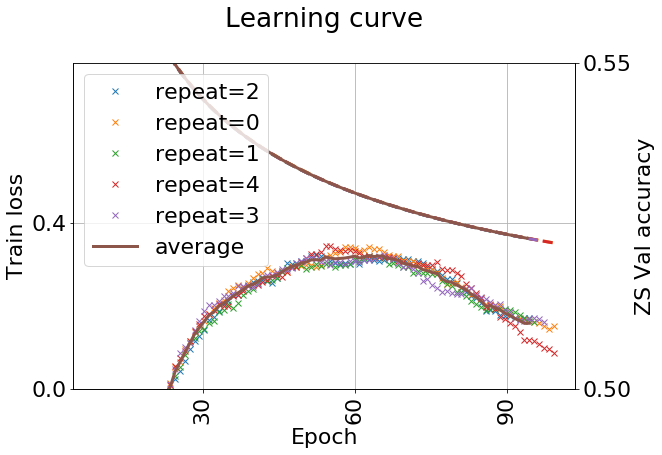

In [19]:
qry = 'isTest==0, Model=="LAGO", ModelType=="LAGO_SemanticSoft", lr==1e-4, β==1e-6, λ==1e-4, muExNorm==1, is_SG==0, rpt!="NA"'
dfmean, dfstd, dfsem, df_counts = df_query_stats(qry, df_cub, metric_keys, verbose=False, query2='rpt<5',  min_counts=0, best_only=False);

print('Mean over repeatitions:')
display(dfmean)

print('\n\nS.E.M (standard error of the mean):')
display(dfsem)

print('')
df_raw_semanticHard = filter_df_by_query_and_sort(df_cub, qry)
fig, ax = plt.subplots(ncols=1, figsize=(9, 6))
plot_LAGO_learning_curve(df_raw_semanticHard, fig, ax, n_mva=10)


## CUB: LAGO - KSoft


### Show accuracy (and SEM) over searched hyper params

In [20]:
qry = 'isTest==0, Model=="LAGO", ModelType=="LAGO_KSoft", rpt!="NA"'
dfmean, dfstd, dfsem, df_counts = df_query_stats(qry, df_cub, metric_keys, verbose=False, query2='rpt<5',  min_counts=0, best_only=False);

print('Mean over repeatitions:')
display(dfmean)

print('\n\nS.E.M (standard error of the mean):')
display(dfsem)

print('\n\nExperiments count:')
display(df_counts)


Mean over repeatitions:


metric_train_zs_accuracy  \
isTest Model ModelType  lr      mxEp β       λ       ψ   muExNorm K  is_SG SGgain SGlr                             
0      LAGO  LAGO_KSoft 0.00003 200  0.00001 0.00001 0.0 0        30 1     1.0    1.0                      98.13   
                                     0.00100 0.00001 0.0 0        30 1     1.0    1.0                      95.44   

                                                                                        metric_val_zs_accuracy  
isTest Model ModelType  lr      mxEp β       λ       ψ   muExNorm K  is_SG SGgain SGlr                          
0      LAGO  LAGO_KSoft 0.00003 200  0.00001 0.00001 0.0 0        30 1     1.0    1.0                    52.14  
                                     0.00100 0.00001 0.0 0        30 1     1.0    1.0                    51.80



S.E.M (standard error of the mean):


metric_train_zs_accuracy  \
isTest Model ModelType  lr      mxEp β       λ       ψ   muExNorm K  is_SG SGgain SGlr                             
0      LAGO  LAGO_KSoft 0.00003 200  0.00001 0.00001 0.0 0        30 1     1.0    1.0                   0.386571   
                                     0.00100 0.00001 0.0 0        30 1     1.0    1.0                   0.860707   

                                                                                        metric_val_zs_accuracy  
isTest Model ModelType  lr      mxEp β       λ       ψ   muExNorm K  is_SG SGgain SGlr                          
0      LAGO  LAGO_KSoft 0.00003 200  0.00001 0.00001 0.0 0        30 1     1.0    1.0                 0.270206  
                                     0.00100 0.00001 0.0 0        30 1     1.0    1.0                 0.799305



Experiments count:


metric_train_zs_accuracy  \
isTest Model ModelType  lr      mxEp β       λ       ψ   muExNorm K  is_SG SGgain SGlr                             
0      LAGO  LAGO_KSoft 0.00003 200  0.00001 0.00001 0.0 0        30 1     1.0    1.0                          5   
                                     0.00100 0.00001 0.0 0        30 1     1.0    1.0                          5   

                                                                                        metric_val_zs_accuracy  
isTest Model ModelType  lr      mxEp β       λ       ψ   muExNorm K  is_SG SGgain SGlr                          
0      LAGO  LAGO_KSoft 0.00003 200  0.00001 0.00001 0.0 0        30 1     1.0    1.0                        5  
                                     0.00100 0.00001 0.0 0        30 1     1.0    1.0                        5

### Show accuracy, learning curve and early stopping over a selected (best) hyper param

Mean over repeatitions:


,,,,,,,,,,,,,metric_train_zs_accuracy,metric_val_zs_accuracy
isTest,Model,ModelType,lr,mxEp,β,λ,ψ,muExNorm,K,is_SG,SGgain,SGlr,,
0,LAGO,LAGO_KSoft,0.00003,200,0.00001,0.00001,0.0,0,30,1,1.0,1.0,98.13,52.14




S.E.M (standard error of the mean):


,,,,,,,,,,,,,metric_train_zs_accuracy,metric_val_zs_accuracy
isTest,Model,ModelType,lr,mxEp,β,λ,ψ,muExNorm,K,is_SG,SGgain,SGlr,,
0,LAGO,LAGO_KSoft,0.00003,200,0.00001,0.00001,0.0,0,30,1,1.0,1.0,0.386571,0.270206



Mean epoch for early stopping is 173


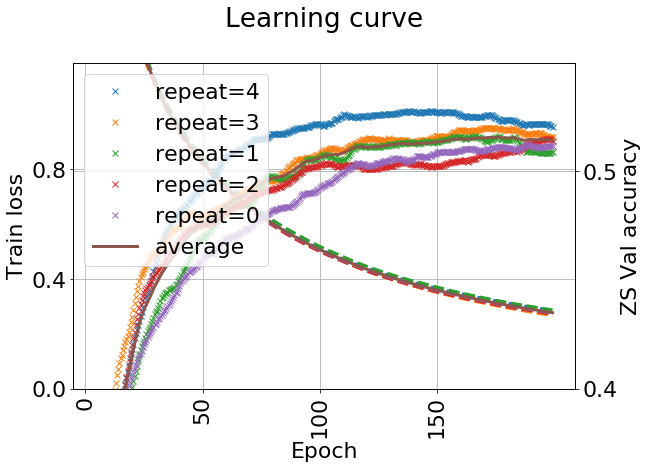

In [21]:
qry = 'isTest==0, Model=="LAGO", ModelType=="LAGO_KSoft", 2e-5<lr<4e-5, β==1e-5, λ==1e-5, muExNorm==0, K==30, is_SG==1, SGgain==1, SGlr==1, rpt!="NA"'
dfmean, dfstd, dfsem, df_counts = df_query_stats(qry, df_cub, metric_keys, verbose=False, query2='rpt<5',  min_counts=0, best_only=False);

print('Mean over repeatitions:')
display(dfmean)

print('\n\nS.E.M (standard error of the mean):')
display(dfsem)

print('')
df_raw_KSoft = filter_df_by_query_and_sort(df_cub, qry)
fig, ax = plt.subplots(ncols=1, figsize=(9, 6))
plot_LAGO_learning_curve(df_raw_KSoft, fig, ax, n_mva=10)